In [1]:
import cu_rsc as cr
cr.setup_tables()
import RSC_sim
import numpy as np
import cupy as cp
import cupyx
import matplotlib.pyplot as plt

M_dev = cr.load_m_table_device()        # upload to GPU
res   = cr.resources_from_config(M_dev)

c:\Users\LyuQi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
seq_ori = np.load("original.npy")

In [3]:
temp = [25e-6, 25e-6, 25e-6]
results = []
k_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for k in k_list:
    mol_0 = cr.build_thermal_molecules_gpu(1_000, temp)
    cr.raman_cool_with_pumping(
        mol_0, 
        seq_ori, 
        res, 
        show_progress=True, 
        k_max=k,)

    result = cr.bootstrap_stats_from_molecules(mol_0)
    results.append(result)


Raman pulses:   0%|          | 0/280 [00:00<?, ?it/s]

Raman pulses: 100%|██████████| 280/280 [00:53<00:00,  5.28it/s]


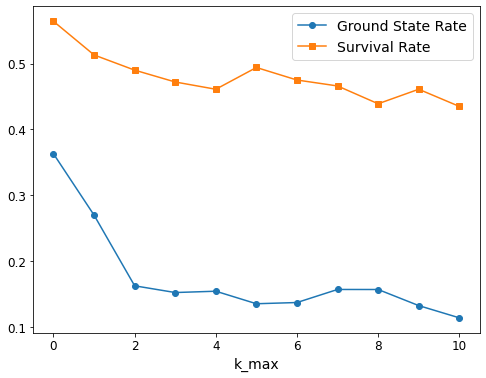

In [4]:
ground_rates = []
survivals = []
for result in results:
    ground_rates.append(result['ground_state_rate_mean'].get())
    survivals.append(result['survival_rate_mean'].get())

plt.figure(figsize=(8,6))
plt.plot(k_list, ground_rates, marker='o', label='Ground State Rate')
plt.plot(k_list, survivals, marker='s', label='Survival Rate')
plt.xlabel('k_max', fontsize=14)
plt.tick_params(labelsize=12)
plt.legend(fontsize=14)

### Vary trap frequency

In [12]:
temp = [25e-6, 25e-6, 25e-6]
results = []
trap_dets = np.linspace(-2e3, 2e3, 11)
for det in trap_dets:
    mol_0 = cr.build_thermal_molecules_gpu(1000, temp)
    cr.raman_cool_with_pumping(
        molecules_dev=mol_0,
        pulses_dev=seq_ori,
        res=res,
        trap_detuning=(0, 0, det),
        show_progress=True
    )
    result = cr.bootstrap_stats_from_molecules(mol_0)
    results.append(result)
    

Raman pulses: 100%|██████████| 280/280 [00:39<00:00,  7.10it/s]


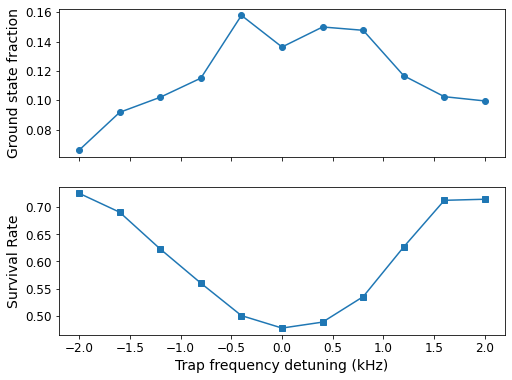

In [18]:
ground_rates = []
survivals = []
for result in results:
    ground_rates.append(result['ground_state_rate_mean'].get())
    survivals.append(result['survival_rate_mean'].get())

fig, ax = plt.subplots(2, 1, figsize=(8,6), sharex=True)
ax[0].plot(trap_dets/1000, ground_rates, marker='o')
ax[0].set_ylabel("Ground state fraction", fontsize=14)
ax[1].plot(trap_dets/1000, survivals, marker='s')
ax[1].set_xlabel('Trap frequency detuning (kHz)', fontsize=14)
ax[1].set_ylabel("Survival Rate", fontsize=14)
ax[0].tick_params(labelsize=12)
ax[1].tick_params(labelsize=12)